In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [3]:
data = list()
tools=["optitype","arcas","rna2hla","hlaforest","seq2hla","hlahd","phlat","hlavbseq",'hlaminer']
#datasets=["1","d2","d3","d4","d5","d6"]
for t in tools:
    total = []
    for d in range(1,7):
        gs=pd.read_csv("../datasets/"+str(d)+"_gs.csv")
        pre=pd.read_csv("../results/standard/"+str(t)+"_d"+str(d)+".csv")
        ret=compute_matches(pre,gs)
        print(t,"d"+str(d),ret)
        total.append(ret)
    data.append(total)

optitype d1 ([6, 0], [8, 0], [280, 0])
optitype d2 ([13, 0], [25, 0], [2892, 0])
optitype d3 ([0, 0], [0, 0], [0, 0])
optitype d4 ([0, 0], [0, 0], [0, 0])
optitype d5 ([4, 0], [0, 0], [4, 0])
optitype d6 ([0, 0], [0, 0], [8, 0])
arcas d1 ([8, 0], [59, 0], [189, 0])
arcas d2 ([38, 6], [95, 99], [2711, 1801])
arcas d3 ([0, 4], [0, 5], [0, 163])
arcas d4 ([0, 24], [0, 0], [0, 4])
arcas d5 ([3, 0], [0, 0], [5, 0])
arcas d6 ([0, 0], [0, 0], [8, 0])
rna2hla d1 ([12, 0], [21, 0], [257, 0])
rna2hla d2 ([37, 45], [78, 33], [2779, 898])
rna2hla d3 ([0, 14], [0, 23], [0, 127])
rna2hla d4 ([0, 20], [0, 1], [0, 5])
rna2hla d5 ([4, 0], [1, 0], [3, 0])
rna2hla d6 ([0, 0], [2, 0], [6, 0])
hlaforest d1 ([20, 0], [31, 0], [233, 0])
hlaforest d2 ([89, 36], [335, 201], [2264, 1663])
hlaforest d3 ([0, 5], [0, 26], [0, 141])
hlaforest d4 ([0, 10], [0, 4], [0, 10])
hlaforest d5 ([4, 0], [2, 0], [2, 0])
hlaforest d6 ([0, 0], [0, 0], [8, 0])
seq2hla d1 ([12, 0], [21, 0], [257, 0])
seq2hla d2 ([37, 111], [78, 1

In [9]:
# sorting through code to calculate Class I and Class II accuracy
data = np.array(data)

classIresults = []
classIIresults = []
allresults = []

for tool in data:
    r = np.sum(np.array(tool),axis=0)
    allresults.append(r[:,0]+r[:,1])
    classIresults.append(r[:,0])
    classIIresults.append(r[:,1])

# normalizing accuracies to 1
classIresults = np.array(classIresults)
row_sums = classIresults.sum(axis=1)
classIresults = classIresults / row_sums[:, np.newaxis]


classIIresults = np.array(classIIresults)
row_sums = classIIresults.sum(axis=1)
classIIresults = classIIresults / row_sums[:, np.newaxis]
np.nan_to_num(classIIresults,0)

allresults = np.array(allresults)
row_sums = allresults.sum(axis=1)
allresults = allresults / row_sums[:, np.newaxis]


print(classIresults)
print(classIIresults)
print(allresults)



[[0.00709877 0.01018519 0.98271605]
 [0.01572529 0.04942234 0.93485237]
 [0.0165625  0.031875   0.9515625 ]
 [0.03781794 0.1231593  0.83902276]
 [0.0165625  0.031875   0.9515625 ]
 [0.05971087 0.04556882 0.8947203 ]
 [0.02815979 0.06024885 0.91159136]
 [0.10084034 0.05042017 0.8487395 ]
 [0.85014104 0.08568406 0.06417489]]
[[0.         0.         0.        ]
 [0.01614435 0.04938272 0.93447293]
 [0.067753   0.04888508 0.88336192]
 [0.02433206 0.11020992 0.86545802]
 [0.0858349  0.09427767 0.81988743]
 [0.06238274 0.03001876 0.9075985 ]
 [0.10927573 0.06416773 0.82655654]
 [0.92634561 0.01369216 0.05996223]
 [0.97400612 0.02599388 0.        ]]
[[0.00709877 0.01018519 0.98271605]
 [0.01589429 0.04940636 0.93469935]
 [0.03023362 0.03641777 0.9333486 ]
 [0.03225806 0.11782061 0.84992132]
 [0.04426107 0.05682671 0.89891223]
 [0.06078284 0.03933007 0.89988709]
 [0.05574762 0.06158168 0.8826707 ]
 [0.43630084 0.03549501 0.52820414]
 [0.900792   0.06127553 0.03793247]]


/var/folders/j4/pd1pbcl90xz683wfkd2drjqw0000gn/T/ipykernel_64828/2963043930.py:22: RuntimeWarning: invalid value encountered in true_divide
  classIIresults = classIIresults / row_sums[:, np.newaxis]


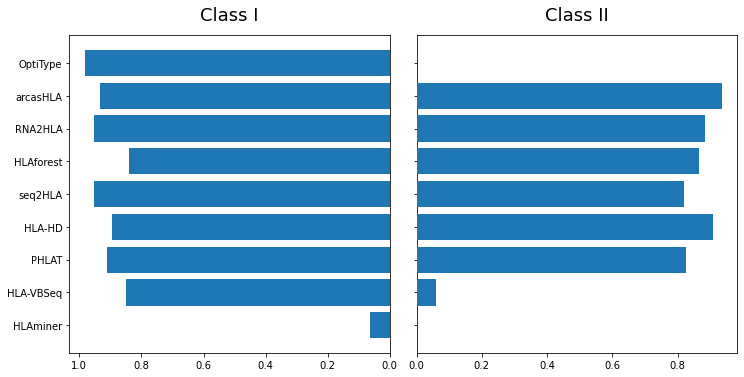

In [10]:
# plotting 0 4dig accuracy

index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer"]
title0 = 'Class I'
title1 = 'Class II'

fourdig_I = classIresults[:,2]
fourdig_II = classIIresults[:,2]

fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, fourdig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, fourdig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

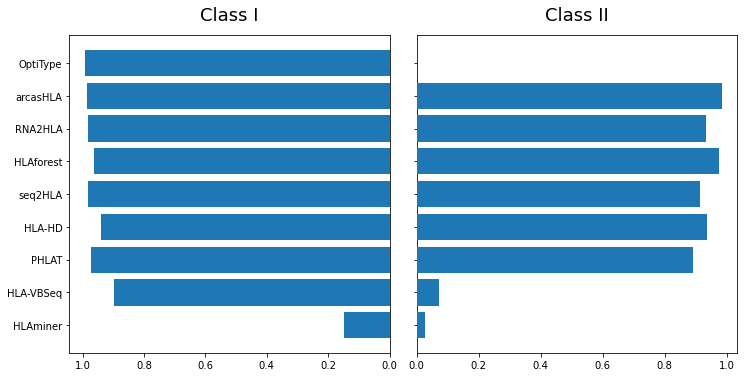

In [12]:
# plotting 2 dig accuracy


index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer"]
title0 = 'Class I'
title1 = 'Class II'
twodig_I = classIresults[:,1]+classIresults[:,2]
twodig_II = classIIresults[:,1]+classIIresults[:,2]


fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, twodig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, twodig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

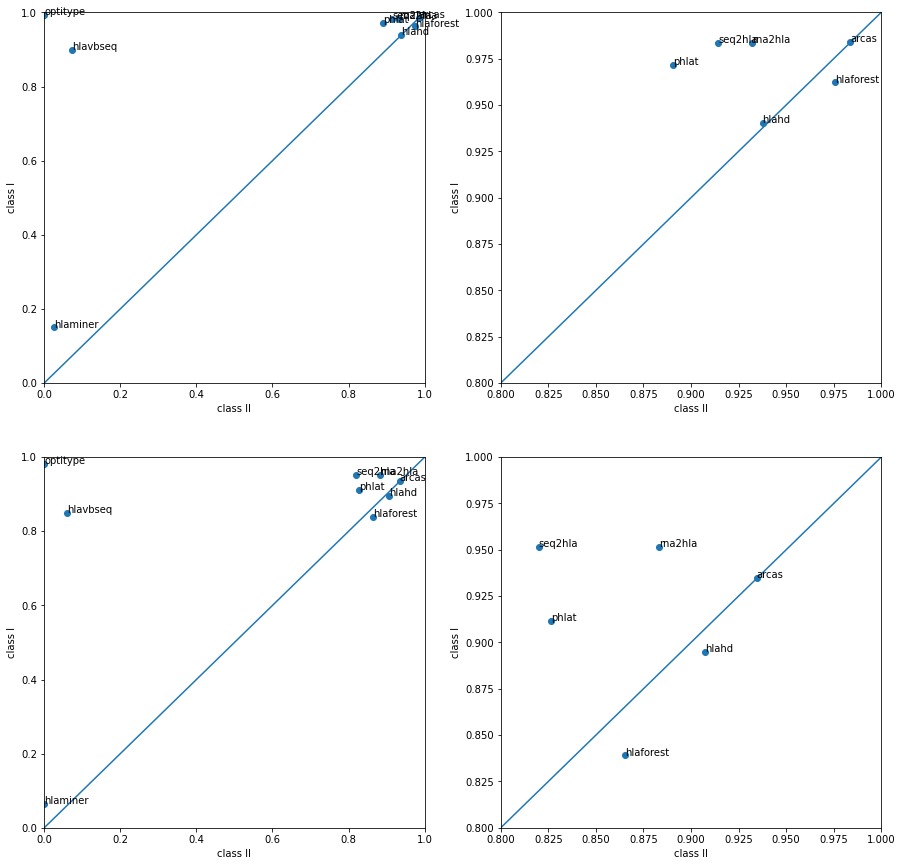

In [13]:
fig, ax = plt.subplots(2, 2,figsize=(15, 15))


ax[0][0].scatter(twodig_II,twodig_I)
for i, txt in enumerate(tools):
    ax[0][0].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][0].set_xlim([0,1])
ax[0][0].set_ylim([0,1])
ax[0][0].set_xlabel("class II")
ax[0][0].set_ylabel("class I")
ax[0][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[0][1].scatter(twodig_II,twodig_I)
for i, txt in enumerate(tools):
    ax[0][1].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][1].set_xlim([0.8,1])
ax[0][1].set_ylim([0.8,1])
ax[0][1].set_xlabel("class II")
ax[0][1].set_ylabel("class I")
ax[0][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[1][0].scatter(fourdig_II,fourdig_I)
for i, txt in enumerate(tools):
    ax[1][0].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][0].set_xlim([0,1])
ax[1][0].set_ylim([0,1])
ax[1][0].set_xlabel("class II")
ax[1][0].set_ylabel("class I")
ax[1][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[1][1].scatter(fourdig_II,fourdig_I)
for i, txt in enumerate(tools):
    ax[1][1].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][1].set_xlim([0.8,1])
ax[1][1].set_ylim([0.8,1])
ax[1][1].set_xlabel("class II")
ax[1][1].set_ylabel("class I")
ax[1][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
